In [1]:
import numpy as np
import os
import random
import sys

sys.path.append('../model')

import config
from game import *
from tileset import *
from mdlstm import *

from time import time

import tensorflow.contrib.slim as slim

Нека изчетем данните. Измежду тях ще изберем само карти за двама играчи, с най-малкия възможен размер (64 X 64), и използващи плочки тип `jungle`. Oчакваме картите да са 11 на брой. Бройката е доста малка, но ще разчитаме на [неразумната ефективност на рекурентните невронни мрежи](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In [2]:
scenarios = []
game = Game(config.STARCRAFT_ROOT)
game.process_game_scenarios()
for directory in config.MAP_DIRECTORIES:
    scenarios += game.process_scenarios(directory)

scenarios = [x for x in scenarios if x.alliances == x.human_players == 2 and x.tileset == Tileset.JUNGLE and x.width == x.height == 64]

len(scenarios)

10

Ще имплементираме помощни функции, които извличат feature-и от плочка. Плочките силно зависят от околните. И може би има смисъл да приложим нещо подобно на word2vec.

Но за сега ще направим малко feature engineering, за да изпробваме модела. Ще работим с 3 feature-а:
- осреднена височина на плочката
- коефициент за това върху каква част от плочката може да се ходи
- дали върху плочката може да се строи

In [3]:
h = 64
w = 64

tile_vec_size = 3
input_vec_size = 2 * tile_vec_size
output_vec_size = tile_vec_size

In [4]:
@np.vectorize
def to_features(tile):

    @np.vectorize
    def minitile_heights(minitile):
        return minitile.height

    @np.vectorize
    def minitile_walkability(minitile):
        return minitile.walkable

    return np.array([
        np.average(minitile_heights(tile.minitiles)),
        np.average(minitile_walkability(tile.minitiles)),
        tile.buildable
    ], dtype=np.float32) + 0.0001

In [5]:
def to_features_by_index(tiles, horizontal_index, vertical_index):
    if vertical_index >= 0 and horizontal_index >= 0:
        tile = tiles[vertical_index, horizontal_index]
        return to_features(tile)
    else:
        return np.zeros([tile_vec_size])

## Експлицитни feature-и на всяка стъпка

Всяка плочка ще зависи от горната и от лявата.

В нашата двуизмерна рекурентна невронна мрежа ще използваме конкатенацията на feature-ите на горната и лявата плочки за вход. За изход ще използваме feature-ите на текущата плочка. За feature-и на плочки извън игралното поле ще връщаме списък нули.

Всъщност скритият state за RNN-а също идва от горната и от лявата плочка. Така че на теория би трябвало да не е нужно да ги даваме експлицитно. Но при по-ранни експерименти имах **огромни** проблеми с числената стабилност на модела. За всякакъв смислено голям learning rate получавах NaN-ове в loss-a. Което всъщност не е изненада. Дори е описано в документацията на модела. Експлицитните feature-и са трик, който се справя с този проблем.

Експлицитните feature-и на всяка стъпка имат още един плюс. Когато използваме модела за генерация, ще можем да избираме плочка различна от най-вероятната за всяка от стъпките.

In [6]:
data = []

for scenario in scenarios:
    x = np.empty((h, w, input_vec_size), dtype=np.float32)
    y = np.empty((h, w, output_vec_size), dtype=np.float32)
    for vertical_index in range(h):
        for horizontal_index in range(w):
            top_tile_features = to_features_by_index(scenario.tiles, vertical_index - 1, horizontal_index)
            left_tile_features = to_features_by_index(scenario.tiles, vertical_index, horizontal_index - 1)
            x[vertical_index, horizontal_index, :] = np.concatenate([top_tile_features, left_tile_features])
            y[vertical_index, horizontal_index, :] = to_features_by_index(scenario.tiles, vertical_index, horizontal_index)
    data.append((x, y))

In [9]:
def batches(data, batch_size, epochs):
    all_batches = []
    for epoch in range(epochs):
        random.shuffle(data)
        all_batches += data

    for i in range(0, epochs * len(data), batch_size):
        inputs = all_batches[i: i + batch_size]
        if len(inputs) == batch_size:
            yield inputs

## Терниране на модела

Моделът идващ от модула `mdlstm`, както и кодът в тази тетрадка се базира на [tensorflow-multi-dimensional-lstm](https://github.com/philipperemy/tensorflow-multi-dimensional-lstm) написан от [Philippe Rémy](https://github.com/philipperemy) с разни промени от моя страна.

Нека на базата на този код да имплементираме примерен трениращ код и да проверим дали моделът конвергира.

In [123]:
learning_rate = 3e-3
batch_size = 6
hidden_size = 16
dtype = tf.float32

# with tf.Session() as sess:
with tf.variable_scope('fooo4', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [batch_size, h, w, input_vec_size])
    y = tf.placeholder(dtype, [batch_size, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver(tf.global_variables())

    epochs = 500
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        if step % 10 == 0:
            print('steps = {0} | overall loss = {1:.5f}'.format(str(step).zfill(4), tot_loss_value))

        if tot_loss_value != tot_loss_value:
            break

        if step % 50 == 0:
            saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

        step += 1

    print('steps = {0} | overall loss = {1:.3f}'.format(str(step).zfill(4), tot_loss_value))
    saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

steps = 0000 | overall loss = 0.24446
steps = 0010 | overall loss = 0.18422
steps = 0020 | overall loss = 0.15899
steps = 0030 | overall loss = 0.16026
steps = 0040 | overall loss = 0.14555
steps = 0050 | overall loss = 0.14163
steps = 0060 | overall loss = 0.14052
steps = 0070 | overall loss = 0.13060
steps = 0080 | overall loss = 0.11840
steps = 0090 | overall loss = 0.10667
steps = 0100 | overall loss = 0.09992
steps = 0110 | overall loss = 0.09374
steps = 0120 | overall loss = 0.08738
steps = 0130 | overall loss = 0.08464
steps = 0140 | overall loss = 0.07915
steps = 0150 | overall loss = 0.07158
steps = 0160 | overall loss = 0.06686
steps = 0170 | overall loss = 0.06214
steps = 0180 | overall loss = 0.05708
steps = 0190 | overall loss = 0.05526
steps = 0200 | overall loss = 0.05008
steps = 0210 | overall loss = 0.04769
steps = 0220 | overall loss = 0.04510
steps = 0230 | overall loss = 0.04351
steps = 0240 | overall loss = 0.04303
steps = 0250 | overall loss = 0.03690
steps = 0260

Моделът конвергира.

## Изследване на хиперпараметрите

In [155]:
dtype = tf.float32

def train(learning_rate, batch_size, hidden_size, variable_scope):
    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
        x = tf.placeholder(dtype, [batch_size, h, w, input_vec_size])
        y = tf.placeholder(dtype, [batch_size, h, w, output_vec_size])

        mdrnn_while_loop = MdRnnWhileLoop(dtype)
        rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
        model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

        loss = tf.reduce_mean(tf.square(y - model_out))
        grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
        sess.run(tf.global_variables_initializer())

        epochs = 10
        step = 0
        for batch in batches(data, batch_size, epochs):
            grad_step_start_time = time()

            model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
                x: np.stack([x[0] for x in batch]),
                y: np.stack([x[1] for x in batch]),
            })

            print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(str(step).zfill(4), tot_loss_value, time() - grad_step_start_time))

            if tot_loss_value != tot_loss_value:
                break

            step += 1

### Нека разгледаме `batch_size`

In [161]:
train(1e-3, 2, 32, 'x1')

steps = 0000 | overall loss = 0.22450 | time 7.404
steps = 0001 | overall loss = 0.23928 | time 4.289
steps = 0002 | overall loss = 0.19042 | time 4.279
steps = 0003 | overall loss = 0.19908 | time 4.880
steps = 0004 | overall loss = 0.18827 | time 4.365
steps = 0005 | overall loss = 0.20849 | time 4.558
steps = 0006 | overall loss = 0.19444 | time 4.335
steps = 0007 | overall loss = 0.18227 | time 4.622
steps = 0008 | overall loss = 0.16794 | time 5.012
steps = 0009 | overall loss = 0.19071 | time 4.355
steps = 0010 | overall loss = 0.18644 | time 4.441
steps = 0011 | overall loss = 0.19184 | time 4.825
steps = 0012 | overall loss = 0.16852 | time 4.884
steps = 0013 | overall loss = 0.18219 | time 4.755
steps = 0014 | overall loss = 0.18980 | time 4.537
steps = 0015 | overall loss = 0.17211 | time 4.524
steps = 0016 | overall loss = 0.17224 | time 4.737
steps = 0017 | overall loss = 0.16989 | time 4.582
steps = 0018 | overall loss = 0.17287 | time 4.516
steps = 0019 | overall loss = 0

In [156]:
train(1e-3, 5, 32, 'x1')

steps = 0000 | overall loss = 0.19480 | time 6.201
steps = 0001 | overall loss = 0.23383 | time 3.631
steps = 0002 | overall loss = 0.19265 | time 3.356
steps = 0003 | overall loss = 0.20216 | time 3.388
steps = 0004 | overall loss = 0.21528 | time 3.364
steps = 0005 | overall loss = 0.18573 | time 3.399
steps = 0006 | overall loss = 0.22116 | time 3.418
steps = 0007 | overall loss = 0.19122 | time 3.432
steps = 0008 | overall loss = 0.19894 | time 3.480
steps = 0009 | overall loss = 0.19380 | time 3.802
steps = 0010 | overall loss = 0.19283 | time 3.816
steps = 0011 | overall loss = 0.17653 | time 4.121
steps = 0012 | overall loss = 0.20932 | time 4.111
steps = 0013 | overall loss = 0.18959 | time 4.088
steps = 0014 | overall loss = 0.19014 | time 4.092
steps = 0015 | overall loss = 0.19537 | time 4.136
steps = 0016 | overall loss = 0.19537 | time 4.045
steps = 0017 | overall loss = 0.19373 | time 4.183
steps = 0018 | overall loss = 0.18951 | time 4.079
steps = 0019 | overall loss = 0

In [160]:
train(1e-3, 8, 32, 'x1')

steps = 0000 | overall loss = nan | time 7.857


**Извод:** По-голям `batch_size` води до по-бързо обучение. Твърде голям води до числена нестабилност.

### Нека разгледаме `learning_rate`

In [163]:
train(0.5, 5, 32, 'x1')

steps = 0000 | overall loss = 0.23959 | time 8.347
steps = 0001 | overall loss = 0.15093 | time 4.893
steps = 0002 | overall loss = 0.16792 | time 4.884
steps = 0003 | overall loss = 0.15135 | time 4.891
steps = 0004 | overall loss = 0.16999 | time 5.683
steps = 0005 | overall loss = 0.17150 | time 5.861
steps = 0006 | overall loss = 0.17436 | time 4.892
steps = 0007 | overall loss = 0.16512 | time 4.920
steps = 0008 | overall loss = 0.17290 | time 4.968
steps = 0009 | overall loss = 0.17663 | time 4.979
steps = 0010 | overall loss = 0.16953 | time 5.051
steps = 0011 | overall loss = 0.17352 | time 5.128
steps = 0012 | overall loss = 0.16673 | time 5.161
steps = 0013 | overall loss = 0.17824 | time 5.123
steps = 0014 | overall loss = 0.17508 | time 5.201
steps = 0015 | overall loss = 0.15553 | time 5.237
steps = 0016 | overall loss = 0.17138 | time 5.228
steps = 0017 | overall loss = 0.18042 | time 5.038
steps = 0018 | overall loss = 0.18573 | time 5.076
steps = 0019 | overall loss = 0

In [164]:
train(0.1, 5, 32, 'x1')

steps = 0000 | overall loss = 0.18755 | time 8.867
steps = 0001 | overall loss = 0.17133 | time 5.844
steps = 0002 | overall loss = 0.13229 | time 6.693
steps = 0003 | overall loss = 0.12600 | time 5.389
steps = 0004 | overall loss = 0.11812 | time 5.167
steps = 0005 | overall loss = 0.11827 | time 4.847
steps = 0006 | overall loss = 0.11511 | time 5.007
steps = 0007 | overall loss = 0.10937 | time 4.914
steps = 0008 | overall loss = 0.09374 | time 4.939
steps = 0009 | overall loss = 0.08826 | time 4.983
steps = 0010 | overall loss = 0.06434 | time 4.954
steps = 0011 | overall loss = 0.06497 | time 4.984
steps = 0012 | overall loss = 0.05683 | time 5.118
steps = 0013 | overall loss = 0.05301 | time 4.972
steps = 0014 | overall loss = 0.04811 | time 4.850
steps = 0015 | overall loss = 0.05483 | time 4.984
steps = 0016 | overall loss = 0.04312 | time 5.709
steps = 0017 | overall loss = 0.05097 | time 5.023
steps = 0018 | overall loss = 0.04086 | time 5.007
steps = 0019 | overall loss = 0

In [165]:
train(0.01, 5, 32, 'x1')

steps = 0000 | overall loss = 0.24318 | time 8.537
steps = 0001 | overall loss = 0.19397 | time 5.208
steps = 0002 | overall loss = 0.23091 | time 5.577
steps = 0003 | overall loss = 0.18486 | time 5.126
steps = 0004 | overall loss = 0.18252 | time 5.016
steps = 0005 | overall loss = 0.20282 | time 5.047
steps = 0006 | overall loss = 0.18599 | time 5.028
steps = 0007 | overall loss = 0.17421 | time 5.189
steps = 0008 | overall loss = 0.18018 | time 5.024
steps = 0009 | overall loss = 0.17664 | time 5.052
steps = 0010 | overall loss = 0.16181 | time 5.108
steps = 0011 | overall loss = 0.17543 | time 5.039
steps = 0012 | overall loss = 0.15204 | time 5.059
steps = 0013 | overall loss = 0.16106 | time 5.031
steps = 0014 | overall loss = 0.15105 | time 5.068
steps = 0015 | overall loss = 0.16661 | time 5.045
steps = 0016 | overall loss = 0.14461 | time 5.023
steps = 0017 | overall loss = 0.15033 | time 6.557
steps = 0018 | overall loss = 0.14266 | time 5.014
steps = 0019 | overall loss = 0

**Извод:** Изненадващо. При по-ранни експерименти всяка малко по-висока стойност на learning rate водеше до числена нестабилност. Възможно е да е било заради по-големият размер на картите (128x128 тогава, 64x64 сега). За сега ще оставим този въпрос отворен.

### Нека разгледаме `hidden_size`

In [171]:
train(0.01, 5, 8, 'x5')

steps = 0000 | overall loss = 0.26832 | time 7.288
steps = 0001 | overall loss = 0.19507 | time 3.657
steps = 0002 | overall loss = 0.21288 | time 3.855
steps = 0003 | overall loss = 0.19213 | time 3.627
steps = 0004 | overall loss = 0.18615 | time 3.628
steps = 0005 | overall loss = 0.18491 | time 3.608
steps = 0006 | overall loss = 0.18188 | time 3.668
steps = 0007 | overall loss = 0.17009 | time 3.612
steps = 0008 | overall loss = 0.18564 | time 3.593
steps = 0009 | overall loss = 0.16213 | time 3.603
steps = 0010 | overall loss = 0.17815 | time 3.651
steps = 0011 | overall loss = 0.16675 | time 3.891
steps = 0012 | overall loss = 0.17001 | time 3.712
steps = 0013 | overall loss = 0.18198 | time 3.710
steps = 0014 | overall loss = 0.15322 | time 3.710
steps = 0015 | overall loss = 0.15681 | time 3.923
steps = 0016 | overall loss = 0.17712 | time 4.003
steps = 0017 | overall loss = 0.16453 | time 4.026
steps = 0018 | overall loss = 0.15952 | time 4.041
steps = 0019 | overall loss = 0

In [168]:
train(0.01, 5, 32, 'x2')

steps = 0000 | overall loss = 0.24190 | time 8.845
steps = 0001 | overall loss = 0.19243 | time 5.362
steps = 0002 | overall loss = 0.19146 | time 5.426
steps = 0003 | overall loss = 0.19279 | time 5.388
steps = 0004 | overall loss = 0.18755 | time 5.400
steps = 0005 | overall loss = 0.17310 | time 5.512
steps = 0006 | overall loss = 0.17268 | time 5.598
steps = 0007 | overall loss = 0.16584 | time 5.426
steps = 0008 | overall loss = 0.16395 | time 5.387
steps = 0009 | overall loss = 0.16531 | time 5.583
steps = 0010 | overall loss = 0.15367 | time 7.052
steps = 0011 | overall loss = 0.15557 | time 5.301
steps = 0012 | overall loss = 0.14952 | time 6.330
steps = 0013 | overall loss = 0.16014 | time 5.378
steps = 0014 | overall loss = 0.14689 | time 5.415
steps = 0015 | overall loss = 0.14865 | time 5.512
steps = 0016 | overall loss = 0.14717 | time 5.303
steps = 0017 | overall loss = 0.14969 | time 5.448
steps = 0018 | overall loss = 0.14041 | time 5.460
steps = 0019 | overall loss = 0

In [167]:
train(0.01, 5, 128, 'x4')

steps = 0000 | overall loss = 0.23936 | time 28.969
steps = 0001 | overall loss = 0.18906 | time 25.882
steps = 0002 | overall loss = 0.18992 | time 26.147
steps = 0003 | overall loss = 0.18570 | time 26.899
steps = 0004 | overall loss = 0.18603 | time 27.369
steps = 0005 | overall loss = 0.16311 | time 28.521
steps = 0006 | overall loss = 0.15637 | time 26.775
steps = 0007 | overall loss = 0.15852 | time 26.869
steps = 0008 | overall loss = 0.14762 | time 27.390
steps = 0009 | overall loss = 0.14391 | time 26.984
steps = 0010 | overall loss = 0.14746 | time 26.791
steps = 0011 | overall loss = 0.14289 | time 26.477
steps = 0012 | overall loss = 0.14387 | time 25.718
steps = 0013 | overall loss = 0.12873 | time 25.919
steps = 0014 | overall loss = 0.13779 | time 28.071
steps = 0015 | overall loss = 0.14269 | time 28.430
steps = 0016 | overall loss = 0.13338 | time 25.671
steps = 0017 | overall loss = 0.13118 | time 29.361
steps = 0018 | overall loss = 0.13405 | time 26.839
steps = 0019

**Извод:** Ефект има. Но е почти пренебрежим. За сметка на доста по-бавно време за трениране. С по-дълги тренирания може да видим по-смислена разлика. Нека пробваме по-дълго трениране...

In [172]:
learning_rate = 2e-3
batch_size = 7
hidden_size = 32
dtype = tf.float32

# with tf.Session() as sess:
with tf.variable_scope('fooo5', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [batch_size, h, w, input_vec_size])
    y = tf.placeholder(dtype, [batch_size, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver(tf.global_variables())

    epochs = 500
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        if step % 10 == 0:
            print('steps = {0} | overall loss = {1:.5f}'.format(str(step).zfill(4), tot_loss_value))

        if tot_loss_value != tot_loss_value:
            break

        if step % 50 == 0:
            saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

        step += 1

    print('steps = {0} | overall loss = {1:.5f}'.format(str(step).zfill(4), tot_loss_value))
    saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

steps = 0000 | overall loss = 0.24157
steps = 0010 | overall loss = 0.18574
steps = 0020 | overall loss = 0.17465
steps = 0030 | overall loss = 0.16504
steps = 0040 | overall loss = 0.15868
steps = 0050 | overall loss = 0.15054
steps = 0060 | overall loss = 0.14977
steps = 0070 | overall loss = 0.13328
steps = 0080 | overall loss = 0.13253
steps = 0090 | overall loss = 0.12998
steps = 0100 | overall loss = 0.12211
steps = 0110 | overall loss = 0.11872
steps = 0120 | overall loss = 0.11888
steps = 0130 | overall loss = 0.11038
steps = 0140 | overall loss = 0.10638
steps = 0150 | overall loss = 0.09887
steps = 0160 | overall loss = 0.10004
steps = 0170 | overall loss = 0.09228
steps = 0180 | overall loss = 0.09305
steps = 0190 | overall loss = 0.08365
steps = 0200 | overall loss = 0.08484
steps = 0210 | overall loss = 0.07976
steps = 0220 | overall loss = 0.07927
steps = 0230 | overall loss = 0.07513
steps = 0240 | overall loss = 0.07296
steps = 0250 | overall loss = 0.06869
steps = 0260

In [62]:
learning_rate = 2e-3
batch_size = 7
hidden_size = 64
dtype = tf.float32

with tf.variable_scope('fooo6', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver(tf.global_variables())

    epochs = 2000
    step = 0
    for batch in batches(data, batch_size, epochs):
        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        if step % 10 == 0:
            print('steps = {0} | overall loss = {1:.5f}'.format(str(step).zfill(4), tot_loss_value))

        if tot_loss_value != tot_loss_value:
            break

        if step % 50 == 0:
            saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

        step += 1

    print('steps = {0} | overall loss = {1:.5f}'.format(str(step).zfill(4), tot_loss_value))
    saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

steps = 0000 | overall loss = 0.21187
steps = 0010 | overall loss = 0.17123
steps = 0020 | overall loss = 0.15428
steps = 0030 | overall loss = 0.14543
steps = 0040 | overall loss = 0.13634
steps = 0050 | overall loss = 0.12234
steps = 0060 | overall loss = 0.10602
steps = 0070 | overall loss = 0.10388
steps = 0080 | overall loss = 0.09660
steps = 0090 | overall loss = 0.08475
steps = 0100 | overall loss = 0.07905
steps = 0110 | overall loss = 0.07268
steps = 0120 | overall loss = 0.06687
steps = 0130 | overall loss = 0.06302
steps = 0140 | overall loss = 0.05441
steps = 0150 | overall loss = 0.05287
steps = 0160 | overall loss = 0.05104
steps = 0170 | overall loss = 0.04304
steps = 0180 | overall loss = 0.04698
steps = 0190 | overall loss = 0.04179
steps = 0200 | overall loss = 0.03907
steps = 0210 | overall loss = 0.03793
steps = 0220 | overall loss = 0.03540
steps = 0230 | overall loss = 0.03433
steps = 0240 | overall loss = 0.03191
steps = 0250 | overall loss = 0.03108
steps = 0260

steps = 2160 | overall loss = 0.00679
steps = 2170 | overall loss = 0.00659
steps = 2180 | overall loss = 0.00711
steps = 2190 | overall loss = 0.00589
steps = 2200 | overall loss = 0.00651
steps = 2210 | overall loss = 0.00888
steps = 2220 | overall loss = 0.00951
steps = 2230 | overall loss = 0.00762
steps = 2240 | overall loss = 0.00665
steps = 2250 | overall loss = 0.00823
steps = 2260 | overall loss = 0.00601
steps = 2270 | overall loss = 0.00690
steps = 2280 | overall loss = 0.00599
steps = 2290 | overall loss = 0.00608
steps = 2300 | overall loss = 0.00624
steps = 2310 | overall loss = 0.00658
steps = 2320 | overall loss = 0.00798
steps = 2330 | overall loss = 0.00728
steps = 2340 | overall loss = 0.00623
steps = 2350 | overall loss = 0.00629
steps = 2360 | overall loss = 0.00529
steps = 2370 | overall loss = 0.00715
steps = 2380 | overall loss = 0.00633
steps = 2390 | overall loss = 0.00761
steps = 2400 | overall loss = 0.00662
steps = 2410 | overall loss = 0.00717
steps = 2420

На стъпка 780 виждаме, че от по-голям размер на hidden state има доста смисъл. Оставихме второто трениране да мине през повече епохи след стъпка 780 - но това е с друга цел.

**Извод:** След достатъчно голям брой епохи започва да се вижда смисъл от `hidden_size`

## Семпилиране на модела

Ще напишем малко дървен (и ужасно бавен) код, с който да ползваме модела, за да генерираме карти.

In [111]:
def iterate_by_layers(height, width):
    
    def iterate_layer(layer):
        for x in range(layer + 1):
            y = layer - x
            if 0 <= x < width and 0 <= y < height:
                yield (x, y)

    for layer in range(width + height - 1):
        yield iterate_layer(layer)

In [137]:
from numpy import dot
from numpy.linalg import norm

cosine_similarity = lambda a, b: dot(a, b) / (norm(a) * norm(b))

In [141]:
key_func = lambda x: cosine_similarity(x, model_preds[0, 0, 0, :])
sorted(list(map(to_features, Tileset.JUNGLE.tiles)), reverse=True, key=key_func)[0]

array([0.33343333, 1.0001    , 1.0001    ], dtype=float32)

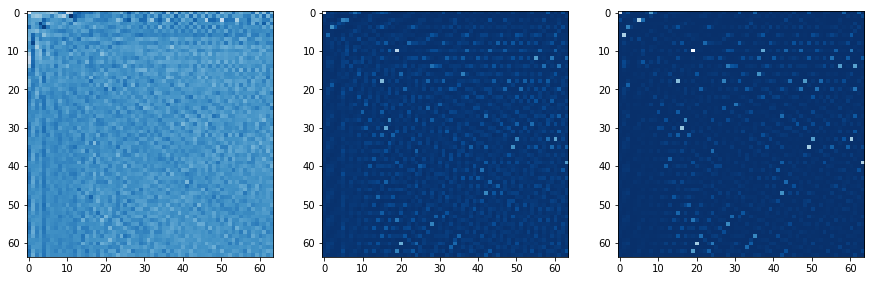

In [145]:
with tf.variable_scope('fooo6', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [1, h, w, input_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    inputs = np.zeros([1, 64, 64, 6])
    ouputs = np.zeros([1, 64, 64, 3])
    
    for layer in iterate_by_layers(64, 64):
        l = list(layer)
        for i, j in l:
            inputs[0, i, j, 0:3] = ouputs[0, i - 1, j, :]
            inputs[0, i, j, 3:6] = ouputs[0, i, j - 1, :]
            
        model_preds = sess.run(model_out, feed_dict={ x: inputs })

        for i, j in l:
            key_func = lambda x: cosine_similarity(x, model_preds[0, i, j, :])
            most_similar_tile_features = sorted(list(map(to_features, Tileset.JUNGLE.tiles)), reverse=True, key=key_func)[0]
            ouputs[0, i, j] = most_similar_tile_features
            
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(model_preds[0, :, :, i], cmap=plt.cm.Blues)
    plt.show()

Това, което виждаме горе са предложенията на модела за всеки от feature-ите на плочките. Те са записани в променливата `model_preds`.

На всяка стъпка взимаме плчоката с feature-и най-близки до предложените и вкарваме feature-ите на реалната плочка обратно в модела. Feature-ите на реалните плочки за записани в `outputs`. Нека видим как изглеждат те...

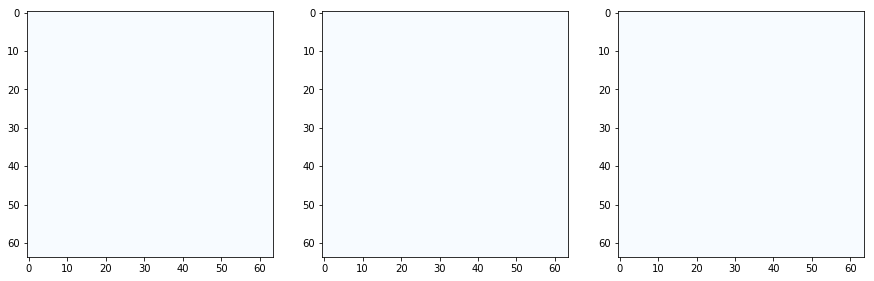

In [150]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(ouputs[0, :, :, i], cmap=plt.cm.Blues)
plt.show()

**Извод:** семплирането е пълен провал.

### Да опитаме да тренираме отново

Този път с по-висок learning rate и по-голям размер на скрития слой.

In [179]:
learning_rate = 0.1
batch_size = 7
hidden_size = 128
dtype = tf.float32

with tf.variable_scope('fooo7', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    epochs = 10
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break

        step += 1

steps = 0000 | overall loss = 0.23238 | time 48.053
steps = 0001 | overall loss = 0.17653 | time 50.446
steps = 0002 | overall loss = 0.13012 | time 43.616
steps = 0003 | overall loss = 0.12293 | time 45.608
steps = 0004 | overall loss = 0.13487 | time 45.471
steps = 0005 | overall loss = 0.13824 | time 47.846
steps = 0006 | overall loss = 0.11992 | time 46.841
steps = 0007 | overall loss = 0.12499 | time 44.547
steps = 0008 | overall loss = 0.11788 | time 49.146
steps = 0009 | overall loss = 0.10472 | time 44.285
steps = 0010 | overall loss = 0.10316 | time 49.340
steps = 0011 | overall loss = 0.10070 | time 49.343
steps = 0012 | overall loss = 0.08847 | time 47.114
steps = 0013 | overall loss = 0.07617 | time 47.578
steps = 0014 | overall loss = 0.07680 | time 47.851


In [183]:
learning_rate = 0.05
batch_size = 7
hidden_size = 128
dtype = tf.float32

with tf.variable_scope('fooo7', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    epochs = 10
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break

        step += 1

steps = 0000 | overall loss = 0.22102 | time 54.358
steps = 0001 | overall loss = 0.19691 | time 49.380
steps = 0002 | overall loss = 0.14738 | time 50.632
steps = 0003 | overall loss = 0.13613 | time 47.807
steps = 0004 | overall loss = 0.12611 | time 46.935
steps = 0005 | overall loss = 0.11668 | time 49.374
steps = 0006 | overall loss = 0.11018 | time 50.137
steps = 0007 | overall loss = 0.10022 | time 54.867
steps = 0008 | overall loss = 0.09497 | time 48.338
steps = 0009 | overall loss = 0.08378 | time 53.585
steps = 0010 | overall loss = 0.07928 | time 52.399
steps = 0011 | overall loss = 0.07206 | time 48.528
steps = 0012 | overall loss = 0.05803 | time 48.583
steps = 0013 | overall loss = 0.05445 | time 51.136
steps = 0014 | overall loss = 0.05386 | time 49.033


In [184]:
learning_rate = 0.02
batch_size = 7
hidden_size = 128
dtype = tf.float32

with tf.variable_scope('fooo7', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    epochs = 10
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break

        step += 1

steps = 0000 | overall loss = 0.21940 | time 63.271
steps = 0001 | overall loss = 0.18806 | time 56.306
steps = 0002 | overall loss = 0.18016 | time 58.864
steps = 0003 | overall loss = 0.15036 | time 55.640
steps = 0004 | overall loss = 0.15220 | time 57.029
steps = 0005 | overall loss = 0.14443 | time 55.713
steps = 0006 | overall loss = 0.15261 | time 56.143
steps = 0007 | overall loss = 0.13811 | time 51.924
steps = 0008 | overall loss = 0.13400 | time 53.753
steps = 0009 | overall loss = 0.13460 | time 56.937
steps = 0010 | overall loss = 0.13012 | time 57.996
steps = 0011 | overall loss = 0.12675 | time 54.856
steps = 0012 | overall loss = 0.12516 | time 55.776
steps = 0013 | overall loss = 0.11822 | time 55.304
steps = 0014 | overall loss = 0.11837 | time 53.279


In [185]:
learning_rate = 0.05
batch_size = 7
hidden_size = 128
dtype = tf.float32

with tf.variable_scope('fooo7', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver(tf.global_variables())
    
    epochs = 400
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([x[0] for x in batch]),
            y: np.stack([x[1] for x in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break

        if step % 50 == 0:
            saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)
            
        step += 1

    saver.save(sess, os.path.join('checkpoints', 'model'), global_step=step)

steps = 0000 | overall loss = 0.22644 | time 64.649
steps = 0001 | overall loss = 0.16291 | time 56.049
steps = 0002 | overall loss = 0.14643 | time 56.156
steps = 0003 | overall loss = 0.12551 | time 55.817
steps = 0004 | overall loss = 0.12539 | time 55.278
steps = 0005 | overall loss = 0.12358 | time 57.295
steps = 0006 | overall loss = 0.11688 | time 57.461
steps = 0007 | overall loss = 0.11106 | time 56.348
steps = 0008 | overall loss = 0.10781 | time 57.328
steps = 0009 | overall loss = 0.09102 | time 59.377
steps = 0010 | overall loss = 0.08235 | time 57.198
steps = 0011 | overall loss = 0.07054 | time 58.629
steps = 0012 | overall loss = 0.06678 | time 57.600
steps = 0013 | overall loss = 0.05754 | time 58.708
steps = 0014 | overall loss = 0.05704 | time 59.194
steps = 0015 | overall loss = 0.04834 | time 58.255
steps = 0016 | overall loss = 0.05195 | time 58.996
steps = 0017 | overall loss = 0.04299 | time 58.363
steps = 0018 | overall loss = 0.04293 | time 58.836
steps = 0019

steps = 0158 | overall loss = 0.01978 | time 65.793
steps = 0159 | overall loss = 0.01960 | time 65.433
steps = 0160 | overall loss = 0.01792 | time 65.900
steps = 0161 | overall loss = 0.01871 | time 65.889
steps = 0162 | overall loss = 0.01761 | time 65.529
steps = 0163 | overall loss = 0.02157 | time 65.062
steps = 0164 | overall loss = 0.01884 | time 65.299
steps = 0165 | overall loss = 0.01892 | time 65.680
steps = 0166 | overall loss = 0.02081 | time 64.583
steps = 0167 | overall loss = 0.01742 | time 65.877
steps = 0168 | overall loss = 0.01832 | time 65.148
steps = 0169 | overall loss = 0.01957 | time 65.725
steps = 0170 | overall loss = 0.01868 | time 65.266
steps = 0171 | overall loss = 0.01644 | time 65.258
steps = 0172 | overall loss = 0.02026 | time 65.048
steps = 0173 | overall loss = 0.01794 | time 65.331
steps = 0174 | overall loss = 0.01705 | time 65.352
steps = 0175 | overall loss = 0.01883 | time 65.036
steps = 0176 | overall loss = 0.01987 | time 65.689
steps = 0177

steps = 0316 | overall loss = 0.01484 | time 67.048
steps = 0317 | overall loss = 0.01287 | time 66.421
steps = 0318 | overall loss = 0.01302 | time 66.899
steps = 0319 | overall loss = 0.01422 | time 67.288
steps = 0320 | overall loss = 0.01320 | time 67.195
steps = 0321 | overall loss = 0.01245 | time 67.322
steps = 0322 | overall loss = 0.01333 | time 67.174
steps = 0323 | overall loss = 0.01286 | time 66.961
steps = 0324 | overall loss = 0.01325 | time 67.120
steps = 0325 | overall loss = 0.01213 | time 66.502
steps = 0326 | overall loss = 0.01264 | time 67.307
steps = 0327 | overall loss = 0.01210 | time 66.844
steps = 0328 | overall loss = 0.01219 | time 67.160
steps = 0329 | overall loss = 0.01470 | time 66.710
steps = 0330 | overall loss = 0.01379 | time 67.027
steps = 0331 | overall loss = 0.01115 | time 67.292
steps = 0332 | overall loss = 0.01271 | time 66.282
steps = 0333 | overall loss = 0.01341 | time 66.818
steps = 0334 | overall loss = 0.01204 | time 66.778
steps = 0335

steps = 0474 | overall loss = 0.01037 | time 68.786
steps = 0475 | overall loss = 0.01051 | time 67.151
steps = 0476 | overall loss = 0.01243 | time 67.063
steps = 0477 | overall loss = 0.01090 | time 66.799
steps = 0478 | overall loss = 0.01116 | time 67.801
steps = 0479 | overall loss = 0.00976 | time 67.915
steps = 0480 | overall loss = 0.01091 | time 67.641
steps = 0481 | overall loss = 0.01234 | time 67.121
steps = 0482 | overall loss = 0.00945 | time 68.052
steps = 0483 | overall loss = 0.01155 | time 67.897
steps = 0484 | overall loss = 0.00928 | time 67.302
steps = 0485 | overall loss = 0.01264 | time 67.783
steps = 0486 | overall loss = 0.00991 | time 67.229
steps = 0487 | overall loss = 0.01197 | time 65.058
steps = 0488 | overall loss = 0.00840 | time 64.647
steps = 0489 | overall loss = 0.01039 | time 64.057
steps = 0490 | overall loss = 0.01004 | time 65.392
steps = 0491 | overall loss = 0.01277 | time 65.324
steps = 0492 | overall loss = 0.01017 | time 64.455
steps = 0493

**Извод:** Не стигаме до нищо по-добро. Изглежда просто feature-ите, които си измислихме не са достатъчно добри. Ще опитаме още неща в нова тетрадка.